## Verification of ADE20K Model

In the main [UNet](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20for%20Computer%20Vision/UNET%20for%20Segmentation) implementation, we trained our model on the Carvana dataset, but this is actually a really simple (as we saw the model learned the segmentation masks in a single epoch!). What I wanted to test was how it also performs on a tougher **ADE20K** dataset. This notebook is just to visualize some of the results from my already trained model!

**NOTE**: 

This is more for demostration purposes, running this notebook means you have the checkpoint *work_dir/UNET_w_skip_ADE20K/best_checkpoint/pytorch_model.bin*. You would get this if you ran *unet_train_ade20k.py*, but there are better models and checkpoints out there, so I wont be providing any weights in this case! Either way, lets see if it worked!

In [53]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from skimage import color
from unet_train_parts import ADE20KDataset, UNET

### Load Model Checkpoint and Dataset ###

We will be just loading out checkpoint here along with our dataset set to *inference_mode*.

In [55]:
### Load Model ###
model = UNET(skip_connection=True, num_classes=150)
model.load_state_dict(torch.load("work_dir/UNET_w_skip_ADE20K/best_checkpoint/pytorch_model.bin"))

### Load Dataset ###
path_to_data = "../../data/ADE20K"
test_data = ADE20KDataset(path_to_data, train=False, inference_mode=True)
test_roots = test_data.file_roots

### Inference Function

This is almost identical to our inference script in the jupyter notebook implementation except for one key difference:
- ADE20K predictions output 150 channels where Carvana only outputs 1. Therefore, instead of thresholding at 50 percent (greater than 50% probability is a car, or its background otherwise), we will just do an argmax to see which value in the 150 channels has the highest likelihood. Also, we trained our model with an image size of 256, so we need to keep it the same in this case as well. 

In [58]:
def inference_image(model, path_to_image, path_to_annotation, colors, image_size=256):

    ### Set Preprocessing Steps ###
    resize = transforms.Resize(size=(image_size, image_size))
    normalize = transforms.Normalize(mean=(0.48897059, 0.46548275, 0.4294), 
                                     std=(0.22861765, 0.22948039, 0.24054667))
    totensor = transforms.ToTensor()
    topil = transforms.ToPILImage()

    ### Load Images ###
    image = Image.open(path_to_image).convert("RGB")
    annot = Image.open(path_to_annotation)
    width, height = annot.size 
    annot = np.array(annot) # This goes from 0 to 150 by default 

    ### Prepare Image for Inference ###
    proc_image = normalize(totensor(resize(image))).unsqueeze(0)

    ### Inference Model ###
    with torch.no_grad():
        pred = model(proc_image)
        
    ### Process Inference ###
    pred = pred.argmax(axis=1).cpu().unsqueeze(0)
    pred = F.interpolate(pred.type(torch.FloatTensor), size=(height, width)).squeeze() 
    pred = np.array(pred, dtype=np.uint8)

    ### Predictions are from 0-149, but 0 is the background class in our data, so add one so it goes 1-150 instead ###
    pred = pred + 1

    ### Overlay Masks on Images ###
    annot_color = color.label2rgb(annot,np.array(image), colors)
    pred_color = color.label2rgb(pred,np.array(image), colors)

    ### Plot Results! ###
    fig, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].imshow(annot_color)
    ax[0].set_title("Ground Truth Segmentation")
    ax[0].axis("off")
    ax[1].imshow(pred_color)
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

### Lets Visualize! 

We will create a random color pallete just so when *color.label2rgb* is plotting it always uses the same colors for every class. 

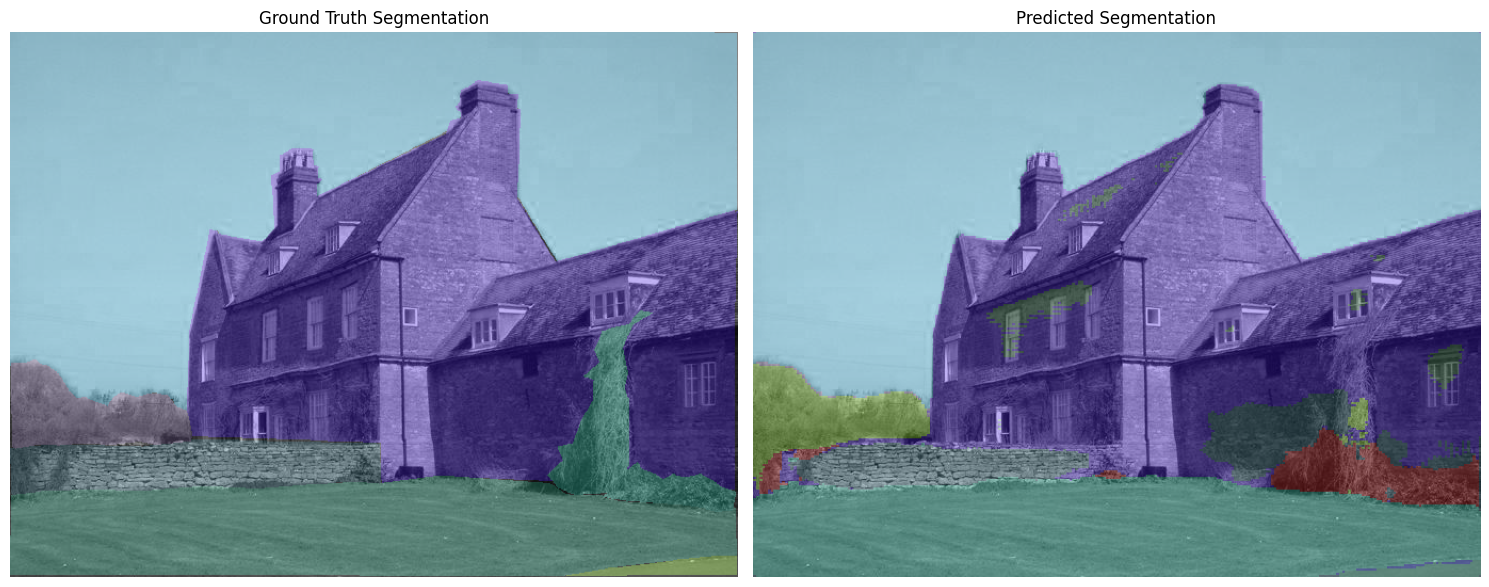

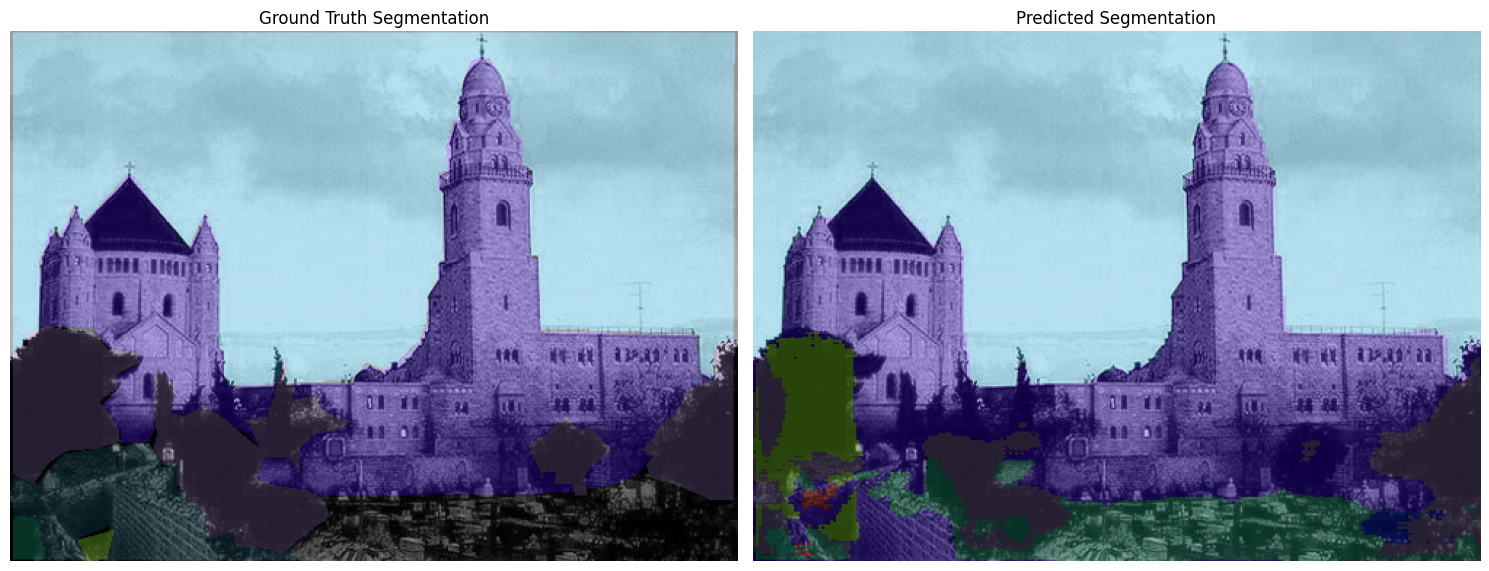

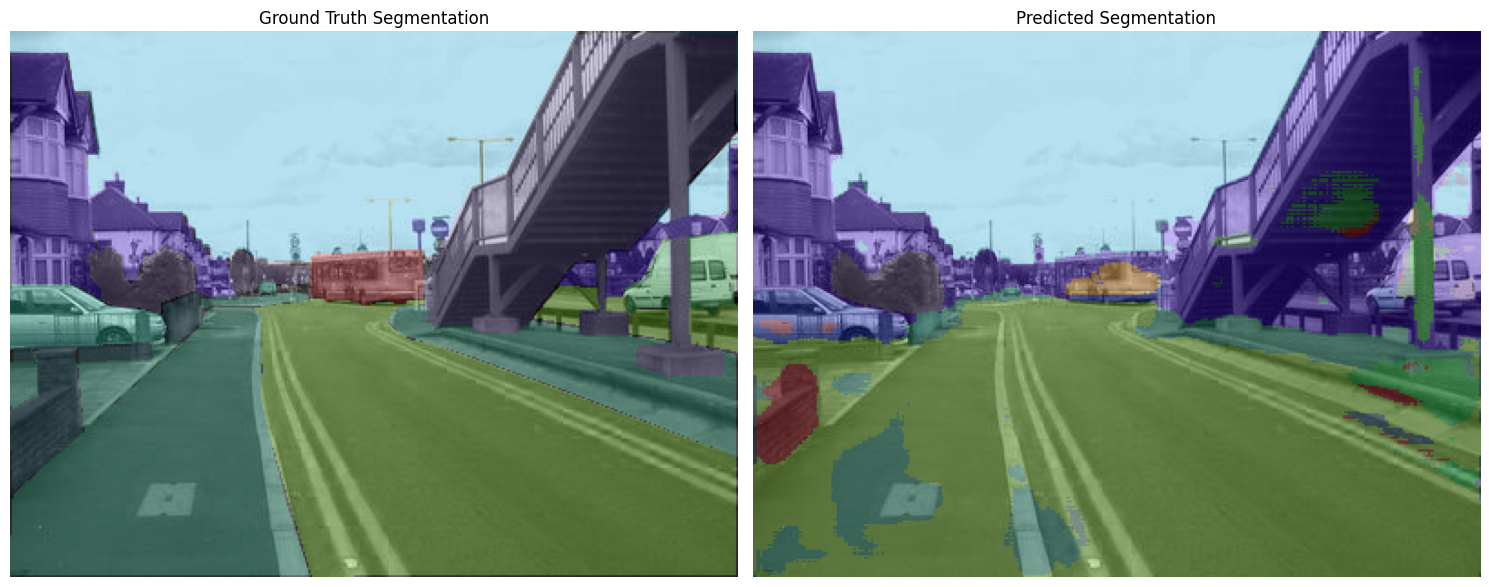

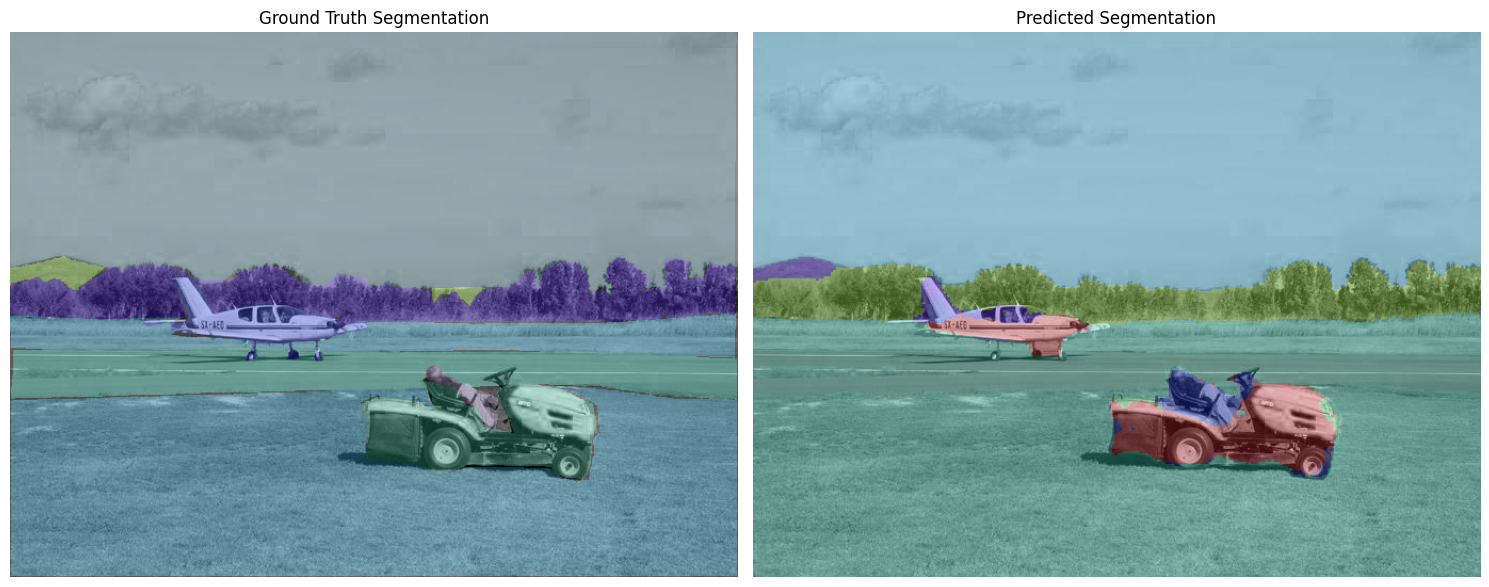

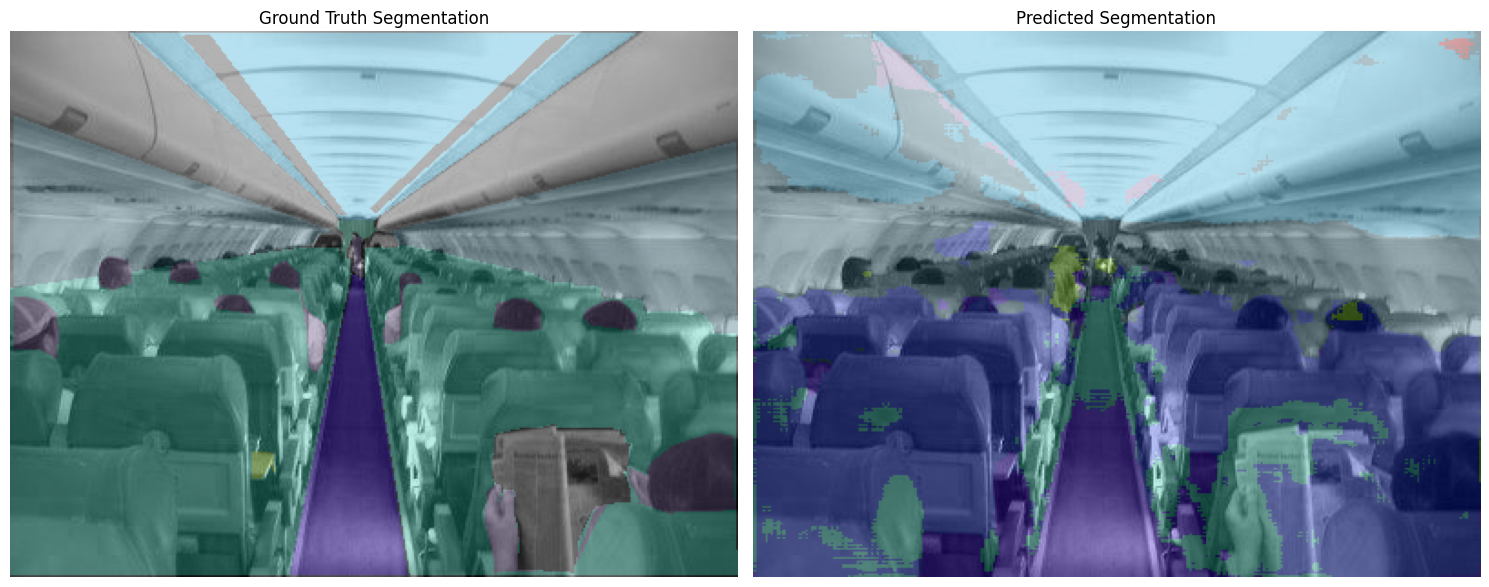

In [61]:
color_pallete = np.random.random((150, 3))

import random
for idx in list(range(5)):
    path_to_image = os.path.join(test_data.path_to_images, test_roots[idx]+".jpg")
    path_to_annotation = os.path.join(test_data.path_to_annotations, test_roots[idx]+".png")
    
    inference_image(model, path_to_image, path_to_annotation, color_pallete)

### Final Thoughts

This is looking pretty good! But there are definitely better models out there that we will implement in the future:

- [UperNet](https://arxiv.org/abs/1807.10221)
- [DeepLabV3](https://arxiv.org/pdf/1706.05587v3)
- [PSPNet](https://arxiv.org/pdf/1612.01105)

